# Xarray-spatial
### User Guide: Focal

#### Use datashader to render our images...
To get started, we'll import numpy and xarray-spatial, along with datashader and a set of its functions to help us quickly render images.

In [1]:
import numpy as np
import xarray as xr

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Generate Terrain Data

The rest of the geo-related functions work with raster data, i.e. data that's been aggregated into the regular row-column grid pattern of a raster. In the code below, the datashader Canvas object helps us do this aggregation and returns a raster in the format of an xarray DataArray. 

To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster (or *digital elevation model - dem*):

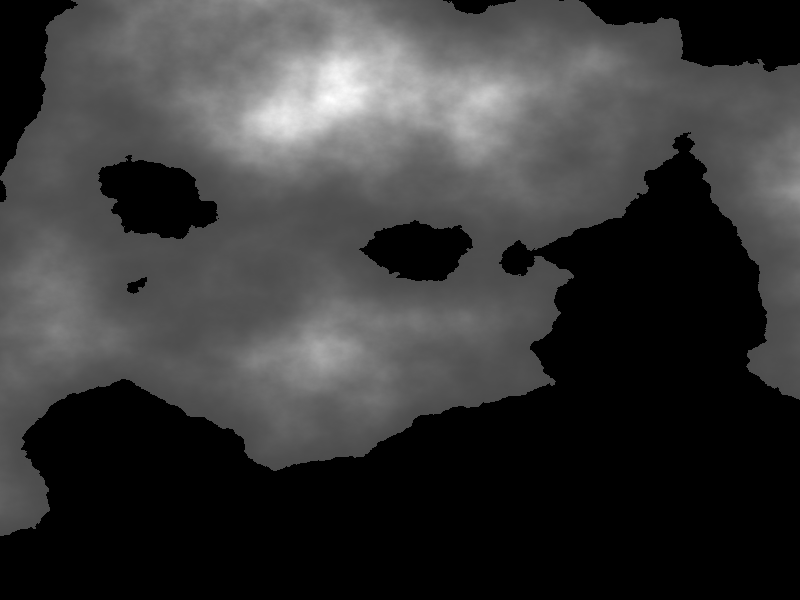

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

template_terrain = xr.DataArray(np.zeros((H, W)))
x_range=(-20e6, 20e6)
y_range=(-20e6, 20e6)

terrain = generate_terrain(template_terrain, x_range=x_range, y_range=y_range)
terrain.attrs["unit"] = "meter"

shade(terrain, cmap=["black", "white"], how="linear")

The grayscale values above show the elevation, scaled linearly in intensity from black to bright white (with the large black areas being low elevation). This gives us a glimpse of a fair amount of detail, but we could make it more intuitive by shading it like a landscape. 

- The Set1 colormap from datashader maps low values to colors representing water and high ones to colors representing mountaintops, with a range of landscape color in between. 
- We'll apply this, but first we'll also apply xarray-spatial's hillshade to give an illuminated representation.

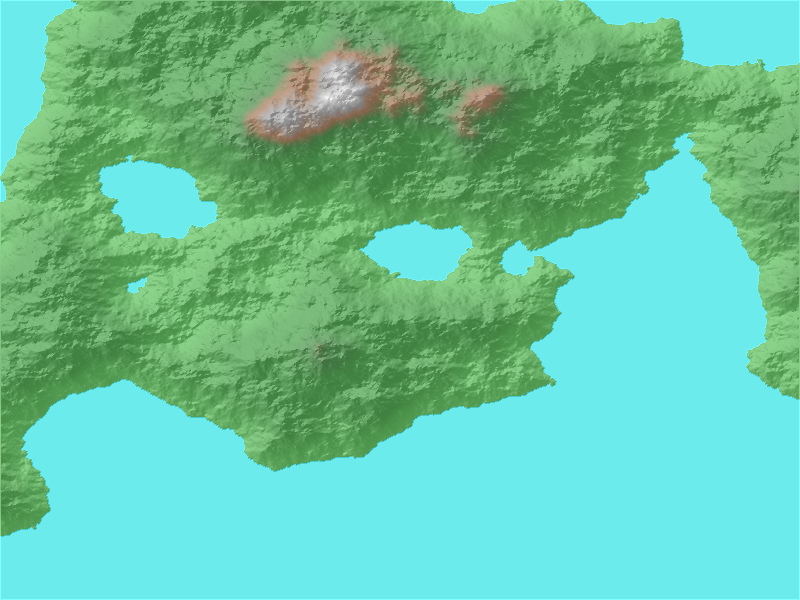

In [3]:
from xrspatial import hillshade
from datashader.colors import Set1
import pandas as pd

terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how="linear")

illuminated = hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=["gray", "white"], alpha=255, how="linear")

stack(illuminated_shaded, terrain_shaded)

## Focal Statistics and Convolutions

Similar to zonal statistics, focal statistics are also used to calculate statistics locally, but relative to a _focal_ point and a neighborhood around that rather than an inflexible zone. The neighborhood is defined with a kernel representing the neighboring cells which should be used in the calculations for each cell. Currently, only circle and annulus kernels are implemented, but any custom kernel can be used, as long as:
- The kernel is a `numpy` array
- The kernel's dimensions are odd: for example, a `3x1` kernel is valid while a `3x2` is not. This is required for symmetry around the focal point in the current implementation.

The following example uses focal statistics to calculate the [topographic position index (TPI)](http://www.jennessent.com/downloads/tpi-poster-tnc_18x22.pdf), a measure of local topographic position (or *elevation*) relative to nearby neighbors. The TPI is scale-dependent and will vary based on the relative sizes of the inner and outer radii in the annulus kernel used, so one TPI does not define *all* TPIs. Once calculated, a TPI can be used to classify slope positions and landforms within landscapes, and can also be used as a numeric feature for model inputs.

We calculate a TPI for our terrain as follows:

- First, we use focal's calc_cellsize to get the scaling right.
- Next, we multiply by a larger and smaller integer for the outer and inner annulus radii, respectively.
- Then, we generate the kernel with annulus_kernel.
- And finally, we use that kernel with focal.apply to calculate the TPI at each point in the terrain.
- To visualize all this, we can shade the TPI and stack it in a composite image with the original terrain. 

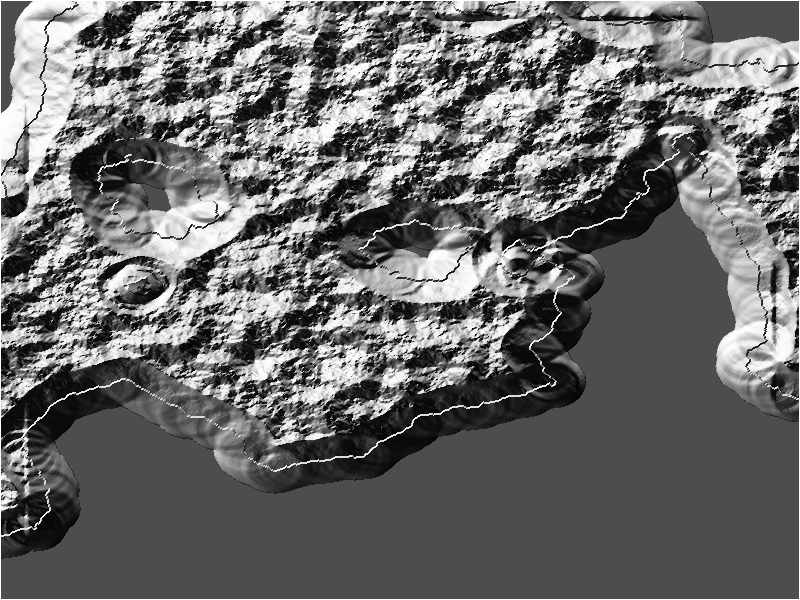

In [4]:
from xrspatial import convolution
from xrspatial import focal

cellsize_x, cellsize_y = convolution.calc_cellsize(terrain)

# Use an annulus kernel with a ring at a distance from 25-30 cells away from focal point
outer_radius = str(cellsize_x * 30) + "m"
inner_radius = str(cellsize_x * 25) + "m"
kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

tpi = terrain - focal.apply(terrain, kernel)

tpi_terrain = hillshade(terrain - focal.apply(terrain, kernel))
tpi_terrain_shaded = shade(
    tpi_terrain, cmap=["white", "black"], alpha=255, how="linear"
)
stack(illuminated_shaded, tpi_terrain_shaded)

### Convolutions

The `focal.apply` function can be computationally expensive depending on the sizes of the kernel and image. Additionally, we'd like to extend focal's capabilities to the use of custom convolution kernels. This is where the `convolution` functions come in.

Let's try an example with [kernels from image processing](https://en.wikipedia.org/wiki/Kernel_(image_processing)). The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is a crude, but computationally inexpensive way to do edge-detection. Let's try setting one up and applying it to our terrain image.

For our example, we'll set up a horizontal Sobel operator, which calculates an approximation of the derivative in the horizontal dimension to get horizontal edges.

(Note: By default, the `convolution` module will use the local CUDA-enabled GPU unit if it is available. To use only the CPU, you can pass `use_cuda=False` to `convolution.convolve_2d`.)

- First, we'll set up a horizontal Sobel kernel manually as a 2D numpy array.  
    Notice the vertical column of zeros and the symmetry on either side of this column.
- Next, we'll apply this kernel to the terrain values to generate a corresponding array of Sobel values.
- Finally, we'll set those values into a DataArray raster with the proper coordinates, dimensions, and attributes from the terrain.  
- To visualize all this, we'll apply hillshade and shade to the sobel terrain and stack it in an image with the original.

Notice all the emphasized horizontal edges. (You can also edit the kernel numbers below to make it vertical and see the vertical edges emphasized, instead.)

Horizontal Sobel Kernel:


array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

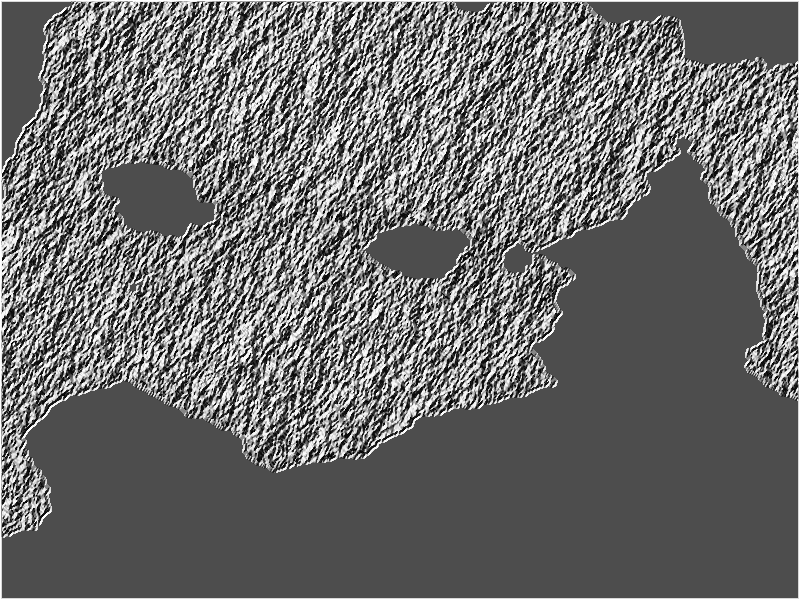

In [5]:
from xrspatial import convolution
from xarray import DataArray

# Use Sobel operator
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
print("Horizontal Sobel Kernel:")
display(kernel)

sobel_values = convolution.convolve_2d(terrain.values, kernel)
sobel = DataArray(
    sobel_values,
    coords=terrain.coords,
    dims=terrain.dims,
    attrs=terrain.attrs,
)
sobel_terrain = hillshade(sobel)
sobel_terrain_shaded = shade(
    sobel_terrain, cmap=["white", "black"], alpha=255, how="linear"
)
stack(illuminated_shaded, sobel_terrain_shaded)